In [ ]:
!pip install kmodes



In [ ]:
# ============================================
# BAGIAN 1: IMPOR & DEFINISI FUNGSI
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler # Pastikan StandardScaler diimpor
from scipy.spatial.distance import cdist # Diperlukan untuk fungsi jarak

# --- FUNGSI JARAK KUSTOM ---
def mixed_distance_corrected(X, categorical_indices, gamma):
    """
    Menghitung pairwise distance matrix untuk data campuran,
    sesuai dengan metrik K-Prototypes.
    X harus berupa numpy array.
    """
    n_samples, n_features = X.shape

    # Pisahkan numerik dan kategorikal
    numeric_indices = [i for i in range(n_features) if i not in categorical_indices]
    X_numeric = X[:, numeric_indices].astype(float)
    X_categorical = X[:, categorical_indices]

    # Hitung Euclidean kuadrat untuk numerik
    if len(numeric_indices) > 0:
        dist_num = cdist(X_numeric, X_numeric, metric='sqeuclidean')
    else:
        dist_num = np.zeros((n_samples, n_samples))

    # Hitung Hamming untuk kategorikal
    if len(categorical_indices) > 0:
        dist_cat = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            dist_cat[i, :] = np.sum(X_categorical[i, :] != X_categorical, axis=1)
    else:
        dist_cat = np.zeros((n_samples, n_samples))

    return dist_num + gamma * dist_cat

# --- FUNGSI SILHOUETTE KUSTOM ---
def kprototypes_silhouette_score(X, labels, categorical_indices, gamma):
    """
    Menghitung silhouette score menggunakan jarak kustom.
    X harus berupa numpy array.
    """
    n_samples = X.shape[0]
    # Menggunakan sampel jika data terlalu besar
    if n_samples > 5000:
        print(f"Dataset besar ({n_samples} baris), mengambil sampel 5000 titik untuk silhouette...")
        np.random.seed(42) # untuk reproduktifitas
        sample_indices = np.random.choice(n_samples, 5000, replace=False)
        X_sample = X[sample_indices]
        labels_sample = labels[sample_indices]
    else:
        X_sample = X
        labels_sample = labels

    # Periksa apakah hanya ada 1 cluster unik (silhouette tidak terdefinisi)
    if len(np.unique(labels_sample)) < 2:
        print("Peringatan: Hanya 1 cluster unik ditemukan dalam sampel, silhouette score tidak terdefinisi.")
        return -1 # Kembalikan skor buruk

    # Hitung matriks jarak HANYA untuk sampel
    print("Menghitung matriks jarak untuk sampel silhouette...")
    dist_matrix = mixed_distance_corrected(X_sample, categorical_indices, gamma)
    print("Selesai menghitung matriks jarak.")

    return silhouette_score(dist_matrix, labels_sample, metric='precomputed')



In [ ]:
# ============================================
# BAGIAN 2: MEMUAT DATA & FEATURE ENGINEERING
# ============================================
print("Memuat dataset...")
df = pd.read_csv('rapih_k-prototypes.csv')
print("Dataset dimuat.")
print("Info data asli:")
df.info()
print("\nContoh data asli:")
print(df.head())

# Pilih fitur relevan
feature_cols = ['Category', 'Item',
                'Days to Due', 'Application Creation Day of Week', 'Is Open Date Off', 'Is Due Date Off',
                 'Application SLA Deadline Day of Week',
                'Application SLA Deadline Hour', 'Average Resolution Time (Ac)', 'Application SLA Compliance Rate', 'Priority']

X = df[feature_cols].copy()

# --- Feature Engineering: Grouping Rare Levels ---
print("\nMemulai proses grouping untuk 'Item' dan 'Category'...")

# Proses kolom 'Item'
top_20_items = X['Item'].value_counts().nlargest(20).index
X['Item'] = X['Item'].apply(lambda x: x if x in top_20_items else 'Other_Item')
print("\nKardinalitas 'Item' setelah digabung:")
print(X['Item'].value_counts().head(21)) # Tampilkan 21 untuk melihat 'Other_Item'

# Proses kolom 'Category'
top_20_categories = X['Category'].value_counts().nlargest(20).index
X['Category'] = X['Category'].apply(lambda x: x if x in top_20_categories else 'Other_Category')
print("\nKardinalitas 'Category' setelah digabung:")
print(X['Category'].value_counts().head(21)) # Tampilkan 21 untuk melihat 'Other_Category'

print("\n--- Selesai Grouping ---")
print("\nContoh data X setelah grouping:")
print(X.head())



Memuat dataset...
Dataset dimuat.
Info data asli:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49836 entries, 0 to 49835
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Number                                49836 non-null  int64  
 1   Priority                              49836 non-null  object 
 2   Category                              49836 non-null  object 
 3   Open Date                             49836 non-null  object 
 4   Closed Date                           49836 non-null  object 
 5   Due Date                              49836 non-null  object 
 6   Time Left Incl. On Hold               49836 non-null  float64
 7   Item                                  49836 non-null  object 
 8   Sub Category                          49836 non-null  object 
 9   Closure Category                      49836 non-null  object 
 10  Is SLA Violated                 

In [ ]:
# ============================================
# BAGIAN 3: SAMPLING & PREPROCESSING
# ============================================
print("\nMelakukan sampling untuk Elbow Method...")
X_sample = X.sample(n=5000, random_state=42)
print(f"Sample shape: {X_sample.shape}")

print("\nMemulai Preprocessing (LabelEncoder & StandardScaler)...")

# Salin X dan X_sample untuk preprocessing
X_processed = X.copy()
X_sample_processed = X_sample.copy()

# 1. Proses Fitur Kategorikal (LabelEncoder)
categorical_cols = X_processed.select_dtypes(include=['object']).columns

label_encoders = {} # Simpan encoder jika perlu transformasi balik
for col in categorical_cols:
    # Gabungkan nilai unik dari kedua set data & pastikan tipe string
    all_values = pd.concat([X_processed[col], X_sample_processed[col]]).astype(str).unique()

    le = LabelEncoder()
    le.fit(all_values)

    # Transformasikan kedua set data & pastikan tipe string
    X_processed[col] = le.transform(X_processed[col].astype(str))
    X_sample_processed[col] = le.transform(X_sample_processed[col].astype(str))
    label_encoders[col] = le # Simpan encoder

print(f"\nKolom kategorikal di-encode: {list(categorical_cols)}")

# 2. Proses Fitur Numerik (StandardScaler)
# Tentukan kolom numerik SETELAH encoding kategorikal
numeric_cols = X_processed.select_dtypes(include=np.number).columns

if not numeric_cols.empty:
    scaler = StandardScaler() # Definisikan scaler
    # Fit scaler HANYA pada data training penuh (X_processed)
    scaler.fit(X_processed[numeric_cols])
    # Transform keduanya
    X_processed[numeric_cols] = scaler.transform(X_processed[numeric_cols])
    X_sample_processed[numeric_cols] = scaler.transform(X_sample_processed[numeric_cols])
    print(f"Kolom numerik di-scale: {list(numeric_cols)}")
else:
    print("Tidak ada kolom numerik untuk di-scale.")

# 3. Hitung Indeks Kategorikal FINAL (berdasarkan X_processed)
categorical_indices = [X_processed.columns.get_loc(c) for c in categorical_cols if c in X_processed.columns]
print(f"Indeks kolom kategorikal setelah proses: {categorical_indices}")

print("\n--- Preprocessing Selesai ---")
print("\nContoh X_processed setelah preprocessing:")
print(X_processed.head())
print("\nInfo X_processed setelah preprocessing:")
X_processed.info()




Melakukan sampling untuk Elbow Method...
Sample shape: (5000, 11)

Memulai Preprocessing (LabelEncoder & StandardScaler)...

Kolom kategorikal di-encode: ['Category', 'Item', 'Application Creation Day of Week', 'Application SLA Deadline Day of Week', 'Priority']
Kolom numerik di-scale: ['Category', 'Item', 'Days to Due', 'Application Creation Day of Week', 'Is Open Date Off', 'Is Due Date Off', 'Application SLA Deadline Day of Week', 'Application SLA Deadline Hour', 'Average Resolution Time (Ac)', 'Application SLA Compliance Rate', 'Priority']
Indeks kolom kategorikal setelah proses: [0, 1, 3, 6, 10]

--- Preprocessing Selesai ---

Contoh X_processed setelah preprocessing:
   Category      Item  Days to Due  Application Creation Day of Week  \
0  0.296511  1.097867    -4.662896                         -1.008510   
1 -0.571418  0.252256    -2.124148                         -1.008510   
2  0.296511  0.956932    -2.124148                         -1.008510   
3 -0.571418  1.238802    -0.4


Memulai Elbow Method...
  Running Elbow k=1...
  Done k=1, cost=30496.12
  Running Elbow k=2...
  Done k=2, cost=23868.98
  Running Elbow k=3...
  Done k=3, cost=20048.93
  Running Elbow k=4...
  Done k=4, cost=17333.88
  Running Elbow k=5...
  Done k=5, cost=14600.37
  Running Elbow k=6...
  Done k=6, cost=13358.34
  Running Elbow k=7...
  Done k=7, cost=12398.42
  Running Elbow k=8...
  Done k=8, cost=11533.77
  Running Elbow k=9...
  Done k=9, cost=10858.19

Membuat plot Elbow...


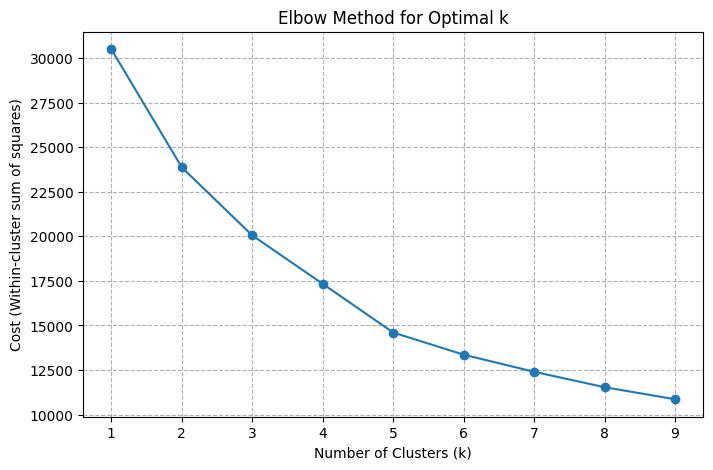


Optimal k yang dipilih berdasarkan plot Elbow: 4

Menjalankan K-Prototypes FINAL dengan k=4...
Pelatihan model final selesai.

Menghitung silhouette score untuk model final...
Dataset besar (49836 baris), mengambil sampel 5000 titik untuk silhouette...
Menghitung matriks jarak untuk sampel silhouette...
Selesai menghitung matriks jarak.

---------------------------------------------------------
SKOR SILHOUETTE MODEL FINAL (k=4): 0.3812
Gamma yang digunakan (Final): 0.5000
---------------------------------------------------------

Memulai analisis hasil cluster final...

Distribusi Ukuran Cluster (Final):
Cluster
3    23796
1    17432
2     5882
0     2726
Name: count, dtype: int64

Crosstab 'Is SLA Violated' vs Cluster (Final):
Is SLA Violated     0      1
Cluster                     
0                1491   1235
1                6368  11064
2                1025   4857
3                9451  14345

Melakukan PCA pada fitur numerik yang sudah discaling...
Explained variance ratio oleh

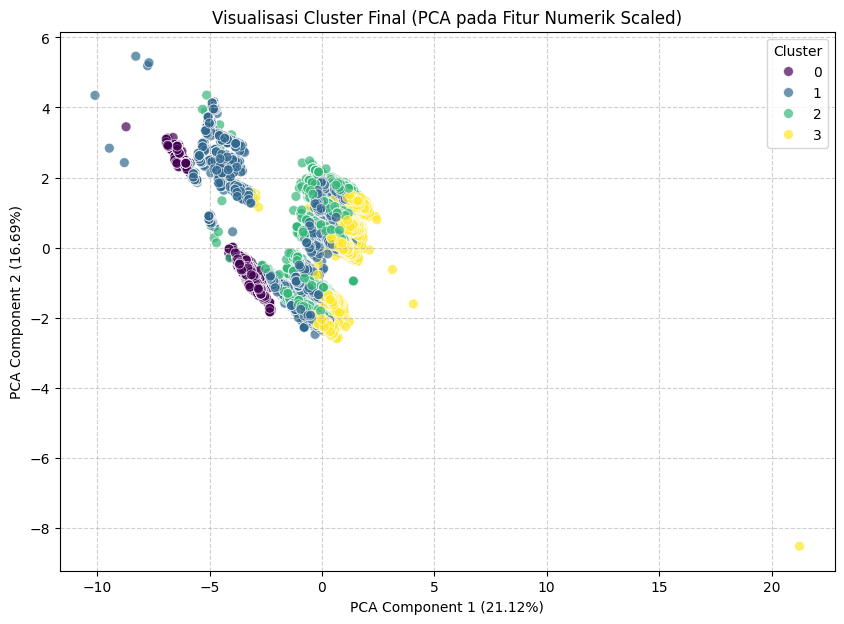


Membuat ringkasan cluster final...

Rata-rata Fitur Numerik (Asli) per Cluster (Final):
        Days to Due                     Is Open Date Off                   \
               mean    median       std             mean median       std   
Cluster                                                                     
0          0.100194  0.106383  0.028960          1.00000    1.0  0.000000   
1          0.128868  0.148936  0.032985          0.00000    0.0  0.000000   
2          0.143290  0.148936  0.013400          0.00085    0.0  0.029146   
3          0.148786  0.148936  0.006240          0.00000    0.0  0.000000   

        Is Due Date Off                  Application SLA Deadline Hour         \
                   mean median       std                          mean median   
Cluster                                                                         
0              0.000367    0.0  0.019153                     16.990095   17.0   
1              0.000000    0.0  0.000000       

In [ ]:
# ============================================
# BAGIAN 4: MENENTUKAN K OPTIMAL (ELBOW METHOD)
# ============================================
print("\nMemulai Elbow Method...")
costs = []
K_max = 9 # Anda bisa menambah K_max jika perlu
for k_elbow in range(1, K_max + 1):
    print(f"  Running Elbow k={k_elbow}...")
    kproto_elbow = KPrototypes(n_clusters=k_elbow, init='Huang', n_init=5, verbose=0, random_state=42)
    # Gunakan data sampel yang sudah diproses (.values agar jadi numpy array)
    kproto_elbow.fit_predict(X_sample_processed.values, categorical=categorical_indices)
    costs.append(kproto_elbow.cost_)
    print(f"  Done k={k_elbow}, cost={kproto_elbow.cost_:.2f}")

# Plot Elbow
print("\nMembuat plot Elbow...")
plt.figure(figsize=(8, 5))
plt.plot(range(1, K_max + 1), costs, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Within-cluster sum of squares)')
plt.xticks(range(1, K_max + 1))
plt.grid(True, linestyle='--')
plt.savefig('elbow_plot.png')
plt.show()

# Tentukan optimal_k berdasarkan plot
optimal_k = 4
print(f"\nOptimal k yang dipilih berdasarkan plot Elbow: {optimal_k}")

# ============================================
# BAGIAN 5: MELATIH MODEL FINAL & EVALUASI
# ============================================
print(f"\nMenjalankan K-Prototypes FINAL dengan k={optimal_k}...")

# Buat model final
kproto_final = KPrototypes(n_clusters=optimal_k,
                           init='Huang',
                           n_init=10, # Tingkatkan n_init untuk model final
                           random_state=42,
                           verbose=0) # Set verbose=1 atau 2 jika ingin lihat proses iterasi

# Latih model pada data penuh yang SUDAH DIPROSES (.values)
clusters_final = kproto_final.fit_predict(X_processed.values, categorical=categorical_indices)
gamma_final = kproto_final.gamma
print("Pelatihan model final selesai.")

# --- HITUNG SKOR SILHOUETTE UNTUK MODEL FINAL ---
print("\nMenghitung silhouette score untuk model final...")

# Hitung skor menggunakan data yang SUDAH DIPROSES (.values)
final_sil_score = kprototypes_silhouette_score(X_processed.values,
                                               clusters_final,
                                               categorical_indices,
                                               gamma_final)

print("\n---------------------------------------------------------")
print(f"SKOR SILHOUETTE MODEL FINAL (k={optimal_k}): {final_sil_score:.4f}")
print(f"Gamma yang digunakan (Final): {gamma_final:.4f}")
print("---------------------------------------------------------")

# ============================================
# BAGIAN 6: ANALISIS HASIL CLUSTER FINAL
# ============================================
print("\nMemulai analisis hasil cluster final...")

# Tambahkan label cluster final ke DataFrame asli
df['Cluster'] = clusters_final

print("\nDistribusi Ukuran Cluster (Final):")
print(df['Cluster'].value_counts())

# Crosstab dengan 'Is SLA Violated' (jika ada)
if 'Is SLA Violated' in df.columns:
    print("\nCrosstab 'Is SLA Violated' vs Cluster (Final):")
    cross_tab_final = pd.crosstab(df['Cluster'], df['Is SLA Violated'])
    print(cross_tab_final)
else:
    print("\nKolom 'Is SLA Violated' tidak ditemukan untuk crosstab.")

# --- PCA dan Visualisasi (menggunakan hasil final) ---
print("\nMelakukan PCA pada fitur numerik yang sudah discaling...")
# Pilih kolom numerik DARI DATA YANG SUDAH DIPROSES
X_processed_numeric = X_processed[numeric_cols].values

pca = PCA(n_components=2, random_state=42)
X_pca_numeric = pca.fit_transform(X_processed_numeric)
print(f"Explained variance ratio oleh PCA: {pca.explained_variance_ratio_}")

# Buat DataFrame untuk plot PCA
df_pca = pd.DataFrame(X_pca_numeric, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters_final # Gunakan cluster FINAL

# Plot hasilnya
print("\nMembuat plot PCA untuk cluster final...")
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Visualisasi Cluster Final (PCA pada Fitur Numerik Scaled)')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('pca_plot_final.png')
plt.show()

# --- Ringkasan Cluster Final ---
print("\nMembuat ringkasan cluster final...")

# Dapatkan kembali nama kolom asli SEBELUM encode/scale (dari X)
categorical_cols_original_names = [col for col in X.select_dtypes(include=['object']).columns if col in X.columns]
numeric_cols_original_names = [col for col in X.select_dtypes(include=np.number).columns if col in X.columns]

# Buat ringkasan numerik dari DATA ASLI (df)
print("\nRata-rata Fitur Numerik (Asli) per Cluster (Final):")
numeric_summary = df.groupby('Cluster')[numeric_cols_original_names].agg(['mean', 'median', 'std'])
print(numeric_summary)

# Buat ringkasan kategorikal dari DATA ASLI (df)
print("\nFitur Kategorikal Paling Umum per Cluster (Final):")
# Gunakan lambda untuk menangani kasus bisa ada >1 modus
categorical_summary = df.groupby('Cluster')[categorical_cols_original_names].agg(lambda x: x.mode().tolist())
print(categorical_summary)

print("\n--- Analisis Selesai ---")

In [ ]:
# ============================================
# BAGIAN 5: MELATIH MODEL FINAL & EVALUASI
# ============================================
print(f"\nMenjalankan K-Prototypes FINAL dengan k={optimal_k}...")

# Buat model final
kproto_final = KPrototypes(n_clusters=optimal_k,
                           init='Huang',
                           n_init=10, # Tingkatkan n_init untuk model final
                           random_state=42,
                           verbose=0) # Set verbose=1 atau 2 jika ingin lihat proses iterasi

# Latih model pada data penuh yang SUDAH DIPROSES (.values)
clusters_final = kproto_final.fit_predict(X_processed.values, categorical=categorical_indices)
gamma_final = kproto_final.gamma
print("Pelatihan model final selesai.")

# --- HITUNG SKOR SILHOUETTE UNTUK MODEL FINAL ---
print("\nMenghitung silhouette score untuk model final...")

# Hitung skor menggunakan data yang SUDAH DIPROSES (.values)
final_sil_score = kprototypes_silhouette_score(X_processed.values,
                                               clusters_final,
                                               categorical_indices,
                                               gamma_final)

print("\n---------------------------------------------------------")
print(f"SKOR SILHOUETTE MODEL FINAL (k={optimal_k}): {final_sil_score:.4f}")
print(f"Gamma yang digunakan (Final): {gamma_final:.4f}")
print("---------------------------------------------------------")




Menjalankan K-Prototypes FINAL dengan k=4...
Pelatihan model final selesai.

Menghitung silhouette score untuk model final...
Dataset besar (49836 baris), mengambil sampel 5000 titik untuk silhouette...
Menghitung matriks jarak untuk sampel silhouette...
Selesai menghitung matriks jarak.

---------------------------------------------------------
SKOR SILHOUETTE MODEL FINAL (k=4): 0.3812
Gamma yang digunakan (Final): 0.5000
---------------------------------------------------------



Memulai analisis hasil cluster final...

Distribusi Ukuran Cluster (Final):
Cluster
3    23796
1    17432
2     5882
0     2726
Name: count, dtype: int64

Crosstab 'Is SLA Violated' vs Cluster (Final):
Is SLA Violated     0      1
Cluster                     
0                1491   1235
1                6368  11064
2                1025   4857
3                9451  14345

Melakukan PCA pada fitur numerik yang sudah discaling...
Explained variance ratio oleh PCA: [0.21119219 0.16690509]

Membuat plot PCA untuk cluster final...


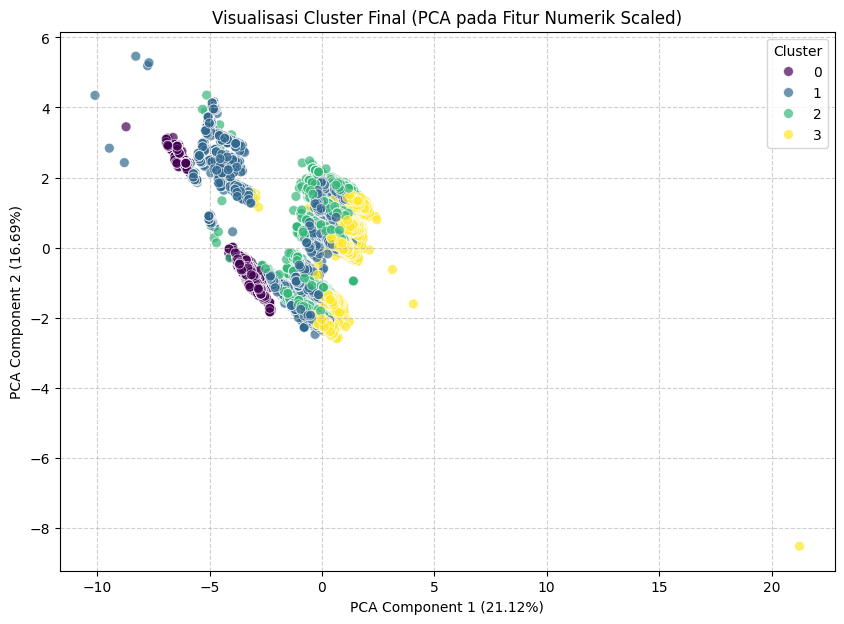


Membuat ringkasan cluster final...

Rata-rata Fitur Numerik (Asli) per Cluster (Final):
        Days to Due                     Is Open Date Off                   \
               mean    median       std             mean median       std   
Cluster                                                                     
0          0.100194  0.106383  0.028960          1.00000    1.0  0.000000   
1          0.128868  0.148936  0.032985          0.00000    0.0  0.000000   
2          0.143290  0.148936  0.013400          0.00085    0.0  0.029146   
3          0.148786  0.148936  0.006240          0.00000    0.0  0.000000   

        Is Due Date Off                  Application SLA Deadline Hour         \
                   mean median       std                          mean median   
Cluster                                                                         
0              0.000367    0.0  0.019153                     16.990095   17.0   
1              0.000000    0.0  0.000000       

In [ ]:
# ============================================
# BAGIAN 6: ANALISIS HASIL CLUSTER FINAL
# ============================================
print("\nMemulai analisis hasil cluster final...")

# Tambahkan label cluster final ke DataFrame asli
df['Cluster'] = clusters_final

print("\nDistribusi Ukuran Cluster (Final):")
print(df['Cluster'].value_counts())

# Crosstab dengan 'Is SLA Violated' (jika ada)
if 'Is SLA Violated' in df.columns:
    print("\nCrosstab 'Is SLA Violated' vs Cluster (Final):")
    cross_tab_final = pd.crosstab(df['Cluster'], df['Is SLA Violated'])
    print(cross_tab_final)
else:
    print("\nKolom 'Is SLA Violated' tidak ditemukan untuk crosstab.")

# --- PCA dan Visualisasi (menggunakan hasil final) ---
print("\nMelakukan PCA pada fitur numerik yang sudah discaling...")
# Pilih kolom numerik DARI DATA YANG SUDAH DIPROSES
X_processed_numeric = X_processed[numeric_cols].values

pca = PCA(n_components=2, random_state=42)
X_pca_numeric = pca.fit_transform(X_processed_numeric)
print(f"Explained variance ratio oleh PCA: {pca.explained_variance_ratio_}")

# Buat DataFrame untuk plot PCA
df_pca = pd.DataFrame(X_pca_numeric, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters_final # Gunakan cluster FINAL

# Plot hasilnya
print("\nMembuat plot PCA untuk cluster final...")
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Visualisasi Cluster Final (PCA pada Fitur Numerik Scaled)')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('pca_plot_final.png')
plt.show()

# --- Ringkasan Cluster Final ---
print("\nMembuat ringkasan cluster final...")

# Dapatkan kembali nama kolom asli SEBELUM encode/scale (dari X)
categorical_cols_original_names = [col for col in X.select_dtypes(include=['object']).columns if col in X.columns]
numeric_cols_original_names = [col for col in X.select_dtypes(include=np.number).columns if col in X.columns]

# Buat ringkasan numerik dari DATA ASLI (df)
print("\nRata-rata Fitur Numerik (Asli) per Cluster (Final):")
numeric_summary = df.groupby('Cluster')[numeric_cols_original_names].agg(['mean', 'median', 'std'])
print(numeric_summary)

# Buat ringkasan kategorikal dari DATA ASLI (df)
print("\nFitur Kategorikal Paling Umum per Cluster (Final):")
# Gunakan lambda untuk menangani kasus bisa ada >1 modus
categorical_summary = df.groupby('Cluster')[categorical_cols_original_names].agg(lambda x: x.mode().tolist())
print(categorical_summary)

print("\n--- Analisis Selesai ---")

In [ ]:
# ============================================
# BAGIAN 7: EKSTRAK HASIL KE JSON UNTUK DJANGO
# ============================================
import json
import numpy as np
import pandas as pd # Pastikan pandas diimpor

print("\nMemulai ekstraksi hasil clustering ke format JSON...")

# --- Variabel dari langkah sebelumnya ---
# Pastikan variabel ini sudah ada dan benar:
# kproto_final, clusters_final, optimal_k, X, X_processed,
# numeric_cols_original_names, categorical_cols_original_names,
# pca, X_pca_numeric

# 1. Ekstrak Hasil Dasar
try:
    # Centroids: Bagian numerik (scaled) + mode kategorikal (encoded)
    centroids = kproto_final.cluster_centroids_
    # Label cluster per baris data
    cluster_labels = clusters_final # Ini sudah berupa numpy array
    # Koordinat PCA (sudah dihitung sebelumnya)
    pca_coords = X_pca_numeric # Ini sudah berupa numpy array
    # Explained variance (dari objek pca yang sudah fit)
    explained_variance = pca.explained_variance_ratio_

except AttributeError as e:
    print(f"Error mengakses atribut model: {e}")
    print("Pastikan model 'kproto_final' sudah di-fit dengan benar.")
    # Handle error sesuai kebutuhan, mungkin keluar dari skrip
    centroids = []
    cluster_labels = []
    pca_coords = []
    explained_variance = []
except NameError as e:
    print(f"Error: Variabel tidak ditemukan - {e}")
    print("Pastikan semua variabel (kproto_final, clusters_final, dll.) sudah didefinisikan.")
    # Handle error
    centroids = []
    cluster_labels = []
    pca_coords = []
    explained_variance = []


# 2. Buat Ringkasan per Cluster (Gunakan Data Asli 'X' untuk Interpretasi)
print("Membuat ringkasan per cluster...")
summary = {}

# Tambahkan label cluster ke DataFrame X (data asli setelah grouping) untuk kemudahan filter
X_with_clusters = X.copy()
# Pastikan panjang clusters_final sesuai dengan X
if len(clusters_final) == len(X_with_clusters):
    X_with_clusters['Cluster'] = clusters_final

    for cluster_id in range(optimal_k):
        mask = (X_with_clusters['Cluster'] == cluster_id)
        cluster_data = X_with_clusters[mask]

        # Rata-rata fitur numerik (dari data asli X)
        mean_num = {}
        if numeric_cols_original_names:
             # Cek apakah cluster_data tidak kosong
             if not cluster_data.empty:
                  mean_num = cluster_data[numeric_cols_original_names].mean().round(4).to_dict()
             else:
                  # Jika cluster kosong, isi dengan NaN atau nilai default
                  mean_num = {col: np.nan for col in numeric_cols_original_names}


        # Modus fitur kategorikal (dari data asli X)
        mode_cat = {}
        if categorical_cols_original_names:
            for col in categorical_cols_original_names:
                # Cek apakah cluster_data tidak kosong dan kolom ada
                if not cluster_data.empty and col in cluster_data:
                    mode_val = cluster_data[col].mode()
                    # Ambil modus pertama jika ada, jika tidak 'Unknown'
                    mode_cat[col] = mode_val.iloc[0] if not mode_val.empty else 'Unknown'
                else:
                    mode_cat[col] = 'Unknown' # Atau nilai default lain

        summary[cluster_id] = {
            'mean_numerical': mean_num,
            'mode_categorical': mode_cat,
            # Gunakan mask.sum() pada Series boolean dari DataFrame asli
            'size': int(mask.sum()) # Konversi ke int standar Python
        }
    # Hapus kolom cluster sementara jika tidak diperlukan lagi
    # del X_with_clusters['Cluster']
else:
    print(f"Error: Panjang label cluster ({len(clusters_final)}) tidak cocok dengan panjang data X ({len(X_with_clusters)}). Ringkasan tidak dapat dibuat.")
    summary = {"error": "Mismatch data length"}


# 3. Gabungkan Semua Hasil ke Dictionary
print("Menggabungkan hasil ke dictionary...")
cluster_results = {
    'num_clusters': optimal_k,
    # Konversi numpy array ke list standar Python untuk JSON
    'centroids': centroids.tolist() if isinstance(centroids, np.ndarray) else centroids,
    'cluster_labels': cluster_labels.tolist() if isinstance(cluster_labels, np.ndarray) else cluster_labels,
    'pca_coords': pca_coords.tolist() if isinstance(pca_coords, np.ndarray) else pca_coords,
    'summary_per_cluster': summary,
    'explained_variance': explained_variance.tolist() if isinstance(explained_variance, np.ndarray) else explained_variance,
    # Tambahkan nama kolom untuk referensi jika perlu (opsional)
    'numerical_columns_summary': numeric_cols_original_names,
    'categorical_columns_summary': categorical_cols_original_names,
}

# 4. Simpan ke File JSON
file_path = 'cluster_results.json'
print(f"Menyimpan hasil ke '{file_path}'...")
try:
    with open(file_path, 'w') as f:
        # Gunakan default=str untuk menangani tipe data numpy yang mungkin tidak serializable
        json.dump(cluster_results, f, indent=4, default=str)
    print(f"Hasil clustering berhasil disimpan ke '{file_path}'!")

    # Tampilkan sampel output JSON
    # print("\nStruktur JSON (sampel):")
    # print(json.dumps(cluster_results, indent=4, default=str)[:1000] + "\n...")

    # # Tes memuat kembali (opsional)
    # try:
    #     with open(file_path, 'r') as f:
    #       loaded_results = json.load(f)
    #     print("\nBerhasil memuat kembali file JSON!")
    #     print(f"Jumlah cluster dari file: {loaded_results.get('num_clusters')}")
    # except json.JSONDecodeError as e:
    #     print(f"\nError saat memuat kembali file JSON: {e}")
    # except Exception as e:
    #     print(f"\nError lain saat memuat kembali: {e}")

except IOError as e:
    print(f"Error: Tidak dapat menulis file JSON - {e}")
except TypeError as e:
    print(f"Error: Tipe data tidak dapat diserialisasi ke JSON - {e}")
    # Jika terjadi TypeError, coba periksa tipe data dalam cluster_results
    # for key, value in cluster_results.items():
    #     print(f"Key: {key}, Type: {type(value)}")
    #     if isinstance(value, list) and value:
    #         print(f"  First item type: {type(value[0])}")
    #     elif isinstance(value, dict) and value:
    #        first_dict_key = next(iter(value))
    #        print(f"  First dict value type: {type(value[first_dict_key])}")

except Exception as e:
    print(f"Terjadi error tak terduga saat menyimpan JSON: {e}")


Memulai ekstraksi hasil clustering ke format JSON...
Membuat ringkasan per cluster...
Menggabungkan hasil ke dictionary...
Menyimpan hasil ke 'cluster_results.json'...
Hasil clustering berhasil disimpan ke 'cluster_results.json'!
